# XGBoost Model for Daily Predictions

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Importing Dataset

In [3]:
dataset = pd.read_csv('final-dataset.csv',
                      parse_dates=['Time'],
                      index_col='Time')
dataset.sort_index(inplace=True)

### Preprocessing Dataset

In [4]:
# Resample data to daily frequency
daily_data = dataset.resample('D').mean()
daily_data['PM2.5'] = daily_data['PM2.5']

In [5]:
# lag features
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['PM2.5'].shift(lag)
    return data
lags = 15
daily_data = create_lag_features(daily_data, lags)
daily_data.dropna(inplace=True)

#### Train Test Split

In [7]:
# Separate features (X) and target variable (y)
X = daily_data.drop(columns=['PM2.5'])
y = daily_data['PM2.5']
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Building XGBoost Model for Daily Predictions

In [8]:
# XGBoost model parameters
params = {
    'objective': 'reg:squarederror',  # Regression
    'eval_metric': 'rmse',            # Evaluation metric
    'max_depth': 3 ,                  # Maximum Depth
    'n_estimators': 100,              # Trees
}
num_rounds = 100
# DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#### Training Model

In [9]:
# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_rounds)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:57:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


#### Making Predictions

In [10]:
# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

### Evaluating Model Performance

In [14]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error (MSE): 22.275255000816824
Root Mean Squared Error (RMSE): 4.719666831548263
Mean Absolute Error (MAE): 3.495050196062055
R-squared: 0.6785582283172543


### Visual Plot for Actual and Predicted Data Points

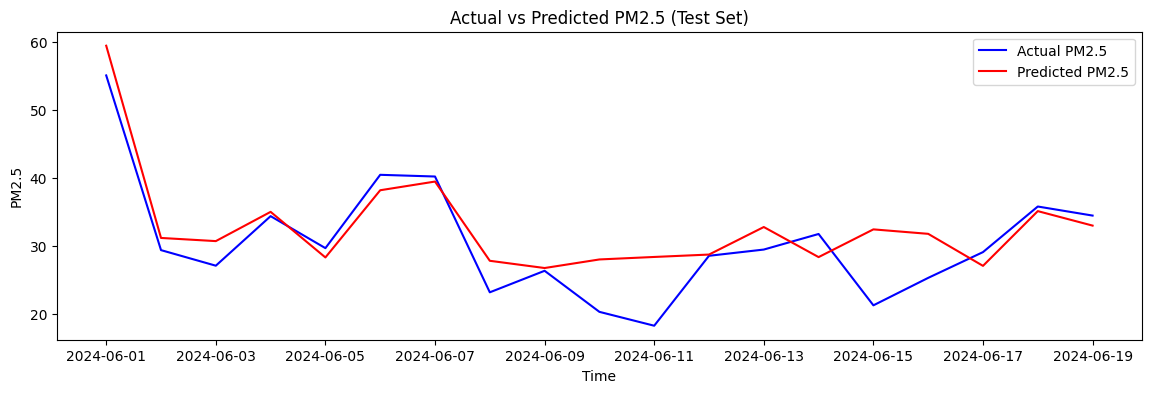

In [17]:
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test, color='blue', label='Actual PM2.5')
plt.plot(y_test.index, y_pred, color='red', label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Test Set)')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()